<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/X4Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time

df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis(1) (1).csv')
df2 = df[df['train'] == 1]
print(df2['y'].max())
ymax_train1 = df2['y'].max()
# sve sa train = 0 y = max(y) + 1

for i in range(df.shape[0]):
  if(df.iloc[i]['train'] == 0):
    df.loc[i, 'y'] = ymax_train1 + 1

lower_bound = df['n'] * df['av.length'] / df['m']
lower_bound = lower_bound.astype('int') + 1

upper_bound = np.minimum(df[' LPTUB'], df[' SLACKUB'])
df['rel. bound'] = (upper_bound-lower_bound)/(upper_bound)
df['rel. bound'] = df['rel. bound']*10000

df['category'] = df['y']
for i in range(df.shape[0]):
  #print(df.iloc[i]['y'])
  if(df.iloc[i]['y'] < 1):
    df.loc[i, 'category'] = 0
  elif(df.iloc[i]['y'] >= 1 and df.iloc[i]['y'] < 10):
    df.loc[i, 'category'] = 1
  else:
    df.loc[i, 'category'] = 2

print(df['category'].max())
print(df['y'].max())




shuffled = df.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus', ' LPTUB', ' SLACKUB', 'train']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']

19.907111
2.0
20.907111


In [2]:
X_modified = X.drop([ 'median','max', 'k', 'av.length', 'range',  'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','n'], axis = 1)
print(X_modified.head())
#X_modified = X.drop(['max', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', '(m/n)^2', '(m/n)^3', 'class', 'av.length'], axis = 1)

    m   n/m     std.dev  min  rel. bound  category
0  48  2.75  137.036362  213  573.453608       1.0
1  30  4.00   49.107903    6  136.986301       0.0
2  12  5.00   46.175968    4   18.484288       0.0
3  40  2.00   15.268153   50   66.225166       0.0
4  12  4.50   19.859192   62  413.223140       0.0


In [3]:
from imblearn.over_sampling import RandomOverSampler

category = X_modified['category']
tmp = X_modified.drop(['category'], axis = 1)
tmp['y'] = y


oversample = RandomOverSampler(random_state=0)
tmp, category = oversample.fit_resample(tmp, category.astype('int'))

tmp = tmp.sample(frac = 1).reset_index()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)
print(X_modified.shape[0])
print(X_modified.head())

21840
   index   m   n/m     std.dev  min   rel. bound
0   5134  40  4.00   46.929787   10   352.112676
1   6637  35  4.00  137.977631  236    63.492063
2   6274  64  2.25   20.675508   35  1171.875000
3   1739  72  2.25  163.480759  168   805.326569
4   3553   8  2.50   11.834272   51  1126.760563


In [4]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return ymax_train1*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(32, activation = 'relu'))
    #classifier.add(Dense(16, activation = 'relu'))

    #model.add(Dense(32, activation='relu'))

    #model.add(Dense(64, activation='relu'))

    #model.add(Dense(8, activation='relu'))
    
    model.add(Dense(1, activation = 'relu'))
    #model.add(Activation(custom_activation, name='SpecialActivation'))
    #model.compile(loss='mean_squared_error', optimizer=tensorflow.keras.optimizers.Adam(clipnorm=1))
    #model.compile(loss='mean_squared_error', optimizer='RMSProp')
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=100, batch_size=32, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/100
567/567 [==============================] - 3s 3ms/step - loss: 43.3487
Epoch 2/100
567/567 [==============================] - 2s 4ms/step - loss: 14.1854
Epoch 3/100
567/567 [==============================] - 2s 3ms/step - loss: 13.3381
Epoch 4/100
567/567 [==============================] - 3s 4ms/step - loss: 12.9578
Epoch 5/100
567/567 [==============================] - 2s 4ms/step - loss: 12.4822
Epoch 6/100
567/567 [==============================] - 2s 3ms/step - loss: 12.1383
Epoch 7/100
567/567 [==============================] - 2s 3ms/step - loss: 11.8535
Epoch 8/100
567/567 [==============================] - 1s 2ms/step - loss: 11.3636
Epoch 9/100
567/567 [==============================] - 1s 2ms/step - loss: 11.1172
Epoch 10/100
567/567 [==============================] - 1s 2ms/step - loss: 10.9019
Epoch 11/100
567/567 [==============================] - 1s 1ms/step - loss: 10.4830
Epoch 12/100
567/567 [==============================] - 1s 2ms/step - loss: 10.3751
E

In [6]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd)) 

117/117 [==============================] - 0s 1ms/step
r_square score:  0.944232696583105
RMSE:


2.1037874818336677

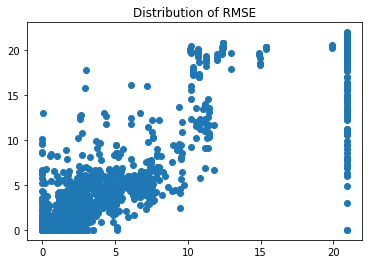

In [7]:
plt.title('Distribution of RMSE')

plt.scatter(yy, predd)

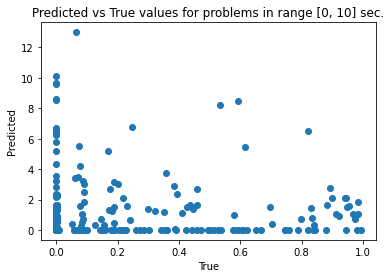

In [8]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]<1):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.title('Predicted vs True values for problems in range [0, 10] sec.')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.scatter(yy_temp, predd_temp)
#plt.ylim([0, 100])

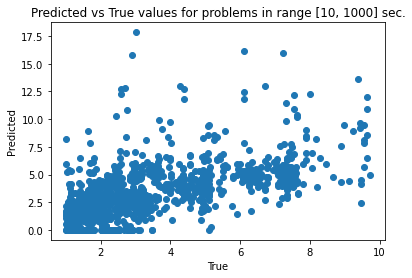

In [9]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=1 and yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.title('Predicted vs True values for problems in range [10, 1000] sec.')
plt.xlabel('True')
plt.ylabel('Predicted')

plt.scatter(yy_temp, predd_temp)

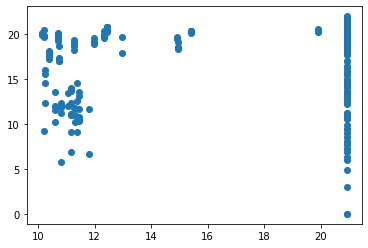

In [10]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

plt.scatter(yy_temp, predd_temp)